# 1.Introduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier,VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white',context='notebook',palette='deep')

# 2.Load and check data

In [2]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')
IDtest = test['PassengerId']

## 2.2 Outlier detection

In [3]:
def detect_outliers(df,n,features):
    
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col=df[(df[col]<Q1 - outlier_step)|(df[col]>Q3+outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v>n)
    
    return multiple_outliers  

In [4]:
Outliers_to_drop = detect_outliers(train,2,['Age','SibSp','Parch','Fare'])


C:\Users\User\Anaconda3\envs\ku\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [5]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [6]:
train = train.drop(Outliers_to_drop,axis=0).reset_index(drop=True)

### 2.3 Jiububg train and test set

In [7]:
train_len = len(train)
dataset = pd.concat(objs = [train,test], axis=0).reset_index(drop=True)

C:\Users\User\Anaconda3\envs\ku\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


### 2.4 Check for null and missing values

In [8]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [9]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3.Feature analysis


### 3.1 Numerical values

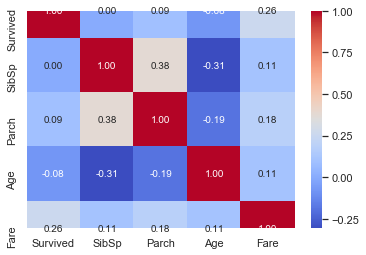

In [13]:
g = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True,fmt='.2f',cmap='coolwarm')

#### SibSp

C:\Users\User\Anaconda3\envs\ku\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\User\Anaconda3\envs\ku\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


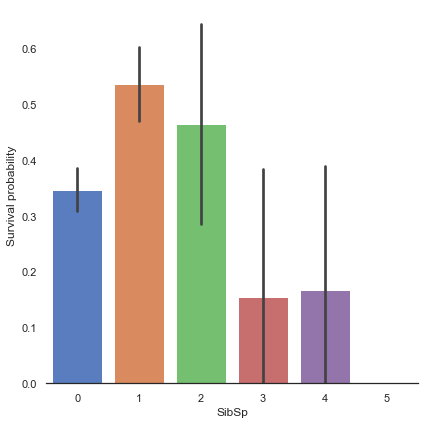

In [14]:
g = sns.factorplot(x='SibSp',y='Survived',data=train,kind='bar',size=6,palette='muted')
g.despine(left=True)
g=g.set_ylabels('Survival probability')

#### Parch

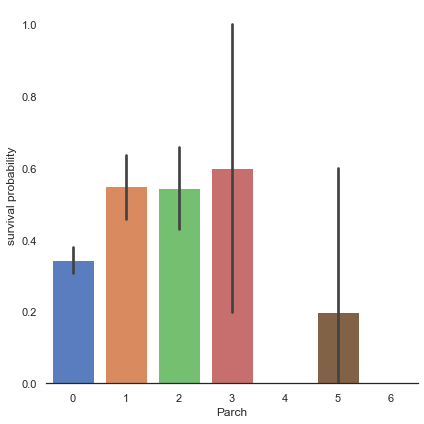

In [15]:
g = sns.factorplot(x='Parch',y='Survived',data=train,kind='bar',size=6,palette='muted')
g.despine(left=True)
g=g.set_ylabels('survival probability')

#### Age

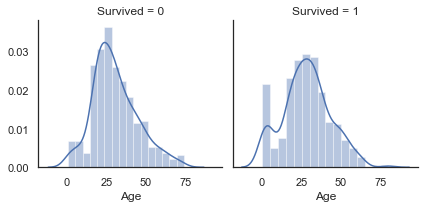

In [16]:
g=sns.FacetGrid(train,col='Survived')
g = g.map(sns.distplot, 'Age')

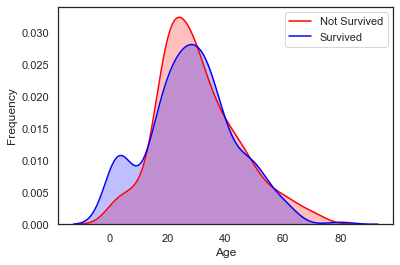

In [17]:
g = sns.kdeplot(train["Age"][(train['Survived']==0)&(train['Age'].notnull())],color='Red',shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1)&(train['Age'].notnull())],ax=g,color='Blue',shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

### Fare

In [18]:
dataset['Fare'].isnull().sum()

1

In [19]:
dataset['Fare']=dataset['Fare'].fillna(dataset['Fare'].median())

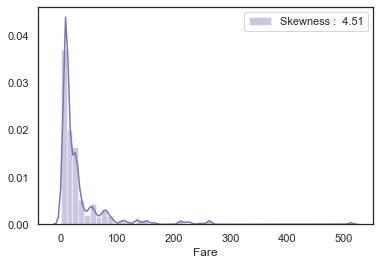

In [20]:
g=sns.distplot(dataset['Fare'],color='m',label='Skewness :  %.2f'%(dataset["Fare"].skew()))
g=g.legend(loc='best')

In [21]:
dataset['Fare']=dataset['Fare'].map(lambda i : np.log(i) if i>0 else 0)

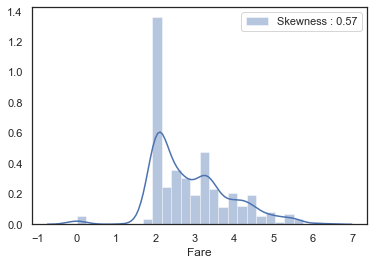

In [22]:
g = sns.distplot(dataset['Fare'],color='b',label='Skewness : %.2f'%dataset['Fare'].skew())
g=g.legend(loc='best')

### 3.2 Categorical values

#### Sex

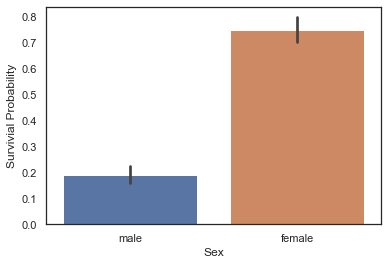

In [23]:
g = sns.barplot(x='Sex',y='Survived',data=train)
g = g.set_ylabel('Survivial Probability')

In [24]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


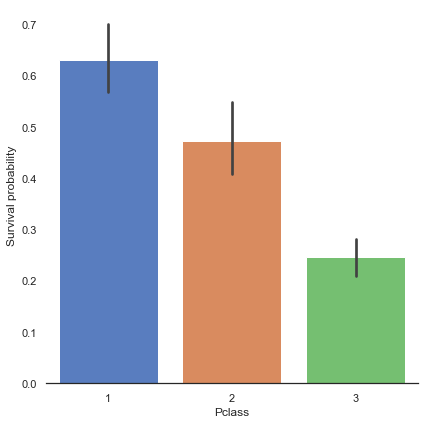

In [25]:
g = sns.factorplot(x='Pclass',y='Survived',data=train, kind='bar',size=6,palette='muted')
g.despine(left=True)
g=g.set_ylabels('Survival probability')

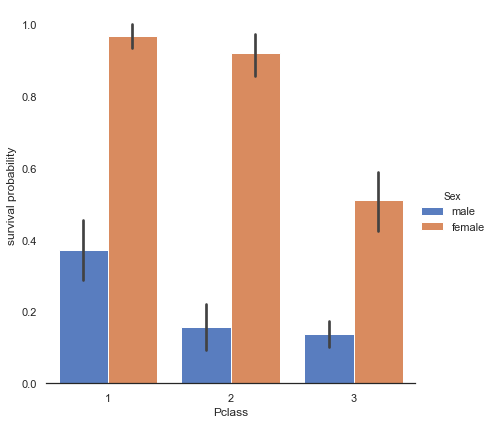

In [26]:
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train , size=6,kind='bar',palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

### Embarked

In [27]:
dataset['Embarked'].isnull().sum()

2

In [28]:
dataset['Embarked']=dataset['Embarked'].fillna('S')

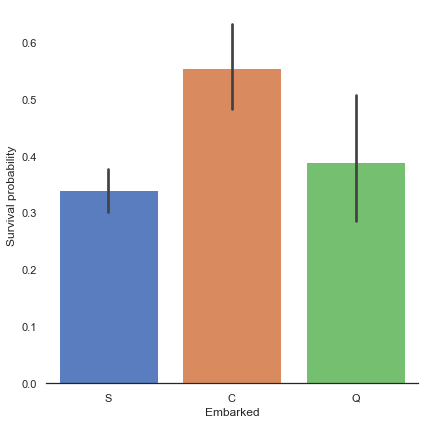

In [29]:
g = sns.factorplot(x='Embarked',y='Survived', data=train, size=6, kind='bar',palette='muted')
g.despine(left=True)
g=g.set_ylabels('Survival probability')

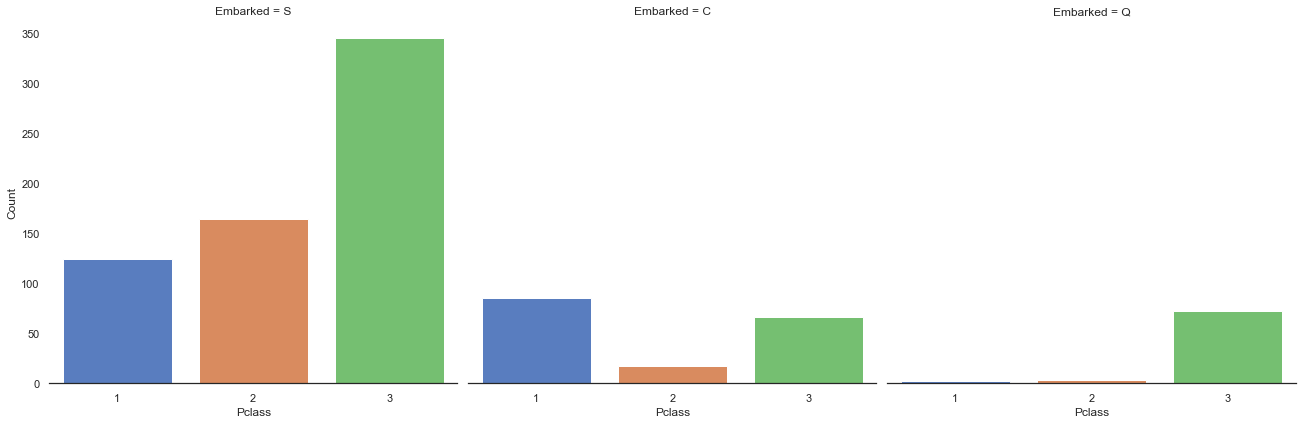

In [30]:
g=sns.factorplot("Pclass",col='Embarked',data=train,size=6,kind='count',palette='muted')
g.despine(left=True)
g=g.set_ylabels('Count')

## Filling missing Values

### 4.1 Age

C:\Users\User\Anaconda3\envs\ku\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\User\Anaconda3\envs\ku\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\User\Anaconda3\envs\ku\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `ca

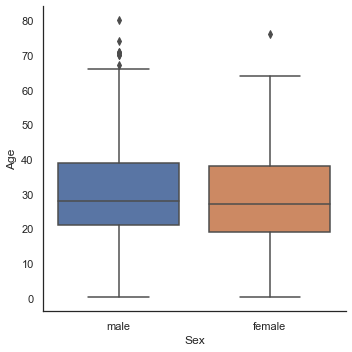

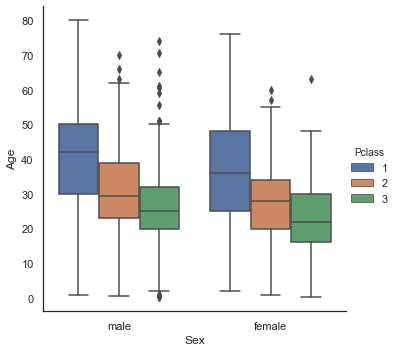

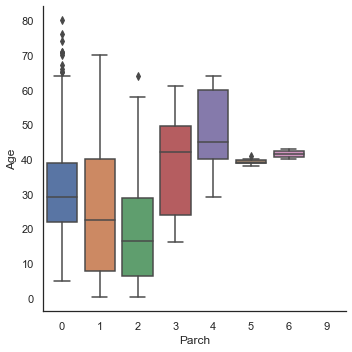

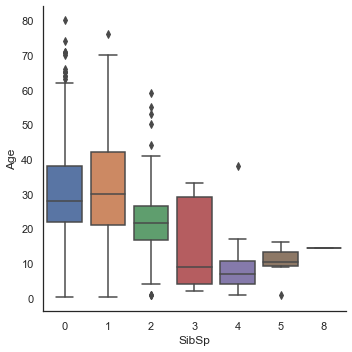

In [31]:
g = sns.factorplot(y='Age',x="Sex",data=dataset, kind='box')
g = sns.factorplot(y='Age',x="Sex",hue='Pclass',data=dataset, kind='box')
g = sns.factorplot(y='Age',x="Parch",data=dataset, kind='box')
g = sns.factorplot(y='Age',x="SibSp",data=dataset, kind='box')


In [32]:
dataset['Sex']=dataset['Sex'].map({'male' :0, "female":1})

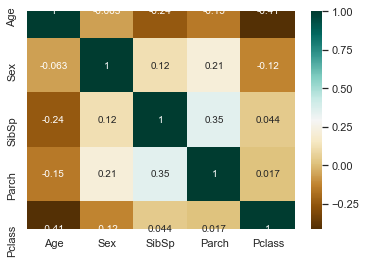

In [33]:
g=sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(),cmap='BrBG',annot=True)

In [34]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp']==dataset.iloc[i]['SibSp'])
                               &(dataset['Parch']==dataset.iloc[i]['Parch'])
                               &(dataset['Pclass']==dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) : 
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med
        

C:\Users\User\Anaconda3\envs\ku\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


C:\Users\User\Anaconda3\envs\ku\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\User\Anaconda3\envs\ku\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


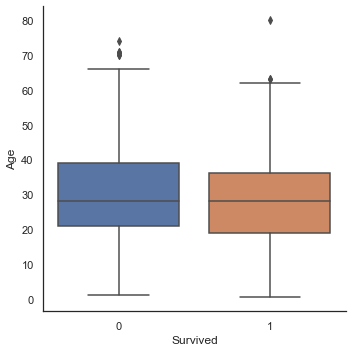

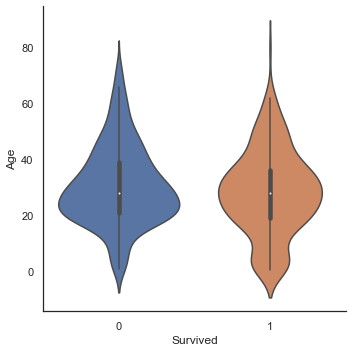

In [35]:
g=sns.factorplot(x='Survived',y='Age',data=train,kind='box')
g=sns.factorplot(x='Survived',y='Age',data=train,kind='violin')

## 5.Feature engineering

### 5.1 Name / Title

In [36]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [37]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

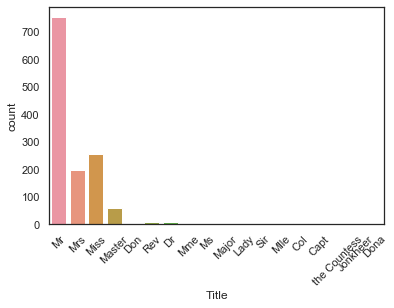

In [38]:
g = sns.countplot(x='Title',data=dataset)
g = plt.setp(g.get_xticklabels(),rotation=45)

In [39]:
dataset["Title"]=dataset['Title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

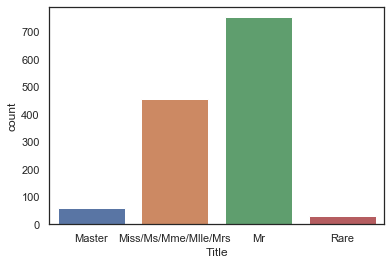

In [40]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs','Mr','Rare'])

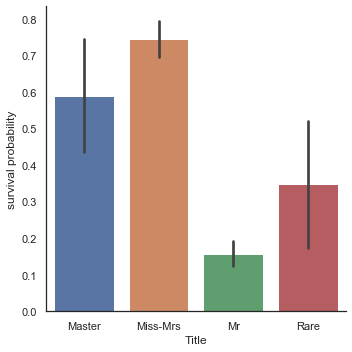

In [41]:
g = sns.factorplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master','Miss-Mrs','Mr','Rare'])
g = g.set_ylabels('survival probability')

In [42]:
dataset.drop(labels = ['Name'],axis=1, inplace=True)

In [43]:
dataset['Fsize']=dataset['SibSp']+dataset['Parch']+1

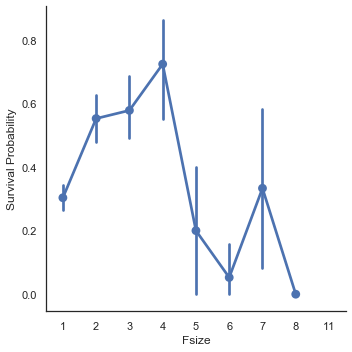

In [44]:
g = sns.factorplot(x='Fsize',y='Survived',data=dataset)
g = g.set_ylabels('Survival Probability')

In [45]:
dataset['Single']=dataset['Fsize'].map(lambda s: 1 if s==1 else 0)
dataset['SmallF']=dataset['Fsize'].map(lambda s: 1 if s==2 else 0)
dataset['MedF']=dataset['Fsize'].map(lambda s: 1 if s<=4 else 0)
dataset['LargeF']=dataset['Fsize'].map(lambda s: 1 if s>=5 else 0)





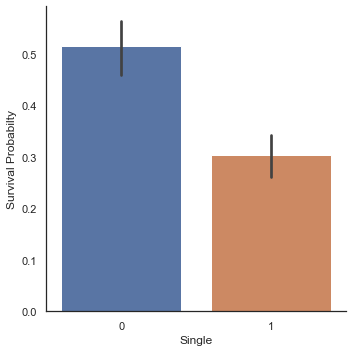

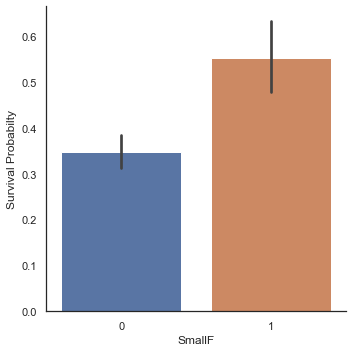

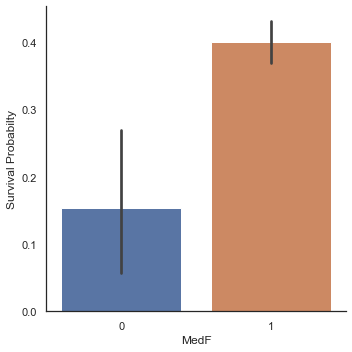

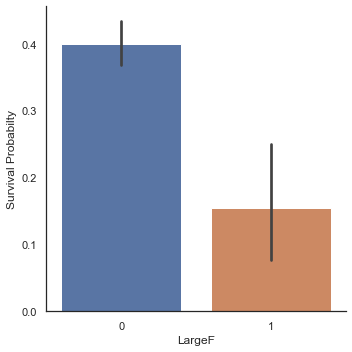

In [46]:
g = sns.factorplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probabilty')
g = sns.factorplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probabilty')
g = sns.factorplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probabilty')
g = sns.factorplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probabilty')

In [47]:
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix='Em')

In [48]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,1,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,1,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,1,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,1,1,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,1,0,0,0,1,0,0,0,1


### Cabin

In [49]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [50]:
dataset["Cabin"].describe()


count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [51]:
dataset['Cabin'].isnull().sum()

1007

In [52]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [53]:
dataset['Cabin']= pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

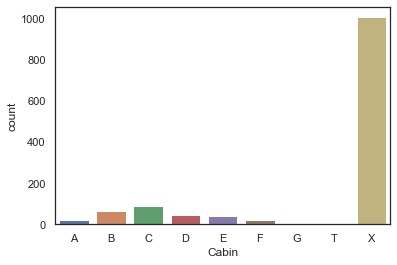

In [54]:
g = sns.countplot(dataset['Cabin'],order=['A','B','C','D','E','F','G','T','X'])

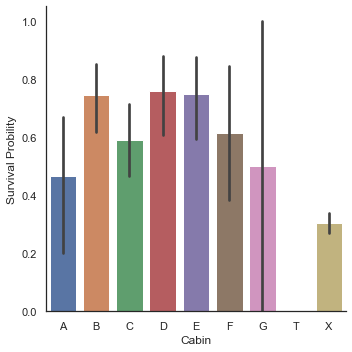

In [55]:
g = sns.factorplot(y='Survived', x='Cabin', data=dataset, kind='bar', order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels('Survival Probility')

In [56]:
dataset = pd.get_dummies(dataset,columns = ['Cabin'],prefix='Cabin')

### 5.4 Ticket

In [57]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [58]:
Ticket = []
for i in list(dataset.Ticket) : 
    if not i.isdigit():
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else :
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [59]:
dataset = pd.get_dummies(dataset,columns = ['Ticket'],prefix='T')

In [60]:
dataset['Pclass']=dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns =['Pclass'],prefix='Pc')

In [61]:
dataset.head()


,Age,Fare,Parch,PassengerId,Sex,SibSp,Survived,Fsize,Single,SmallF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,1,0,1,0.0,2,0,1,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,2,1,1,1.0,2,0,1,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,3,1,0,1.0,1,1,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,4,1,1,1.0,2,0,1,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,5,0,0,0.0,1,1,0,...,0,0,0,0,0,0,1,0,0,1


## 6.Modeling

In [62]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'],axis = 1,inplace=True)

C:\Users\User\Anaconda3\envs\ku\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [63]:
train['Survived'] = train['Survived'].astype(int)

Y_train = train['Survived']

X_train = train.drop(labels = ['Survived'], axis=1)

C:\Users\User\Anaconda3\envs\ku\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### 6.1 Simple modeling

#### 6.1.1 Cross validate modles


* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis


In [64]:
kfold = StratifiedKFold(n_splits=10)

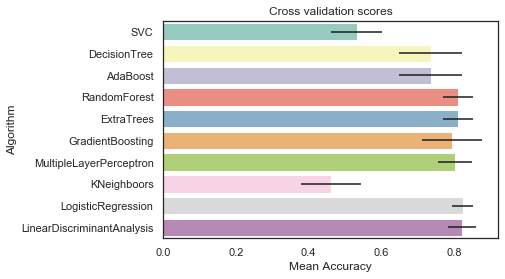

In [66]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []

for classifier in classifiers :
    cv_results.append(cross_val_score(classifier,X_train,y=Y_train,scoring='accuracy',cv=kfold,n_jobs=4))
    
cv_means = []
cv_std =[]

for cv_result in cv_results : 
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot('CrossValMeans','Algorithm',data=cv_res,palette='Set3',orient='h',**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title('Cross validation scores')    
    

### 6.1.2 Hyperparameter tunning for best models

In [71]:
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {'base_estimator__criterion' : ['gini','entropy'],
                 'base_estimator__splitter' : ['best','random'],
                 'algorithm':['SAMME',"SAMME.R"],
                 'n_estimators':[1,2],
                 'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3,1.5]}
gsadaDTC = GridSearchCV(adaDTC,param_grid=ada_param_grid,cv=kfold,scoring='accuracy',n_jobs=4,verbose=1)
gsadaDTC.fit(X_train,Y_train)

adabest=gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 113 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:   10.7s finished
C:\Users\User\Anaconda3\envs\ku\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [73]:
gsadaDTC.best_score_

0.7707150964812712

In [ ]:
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth" : [None]}